<a href="https://colab.research.google.com/github/pandian-ra/EVA4_Session6/blob/master/L2_Weight_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                    #    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                    #    transforms.RandomRotation((-5.0, 5.0), fill=(1,)),                                      
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12
        
        # CONVOLUTION BLOCK 2
        self.convblock22 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # CONVOLUTION BLOCK 3
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),            
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=22, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(22),
            nn.Dropout(dropout_value)
        ) # output_size = 4


        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 3
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=22, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock22(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        # x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             160
           Conv2d-11           [-1, 10, 10, 10]             900
      BatchNorm2d-12           [-1, 10, 10, 10]              20
             ReLU-13           [-1, 10, 10, 10]               0
          Dropout-14           [-1

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR
train_lossesL2 = []
test_lossesL2 = []
train_accL2 = []
test_accL2 = []

for weightInt in range(10):
    weightDecimal = weightInt/10000
    print("Weight Decay :", weightDecimal)
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    model =  Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay= weightDecimal)
    EPOCHS = 10
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader, optimizer, epoch)
        # scheduler.step()
        test(model, device, test_loader)
    
    train_lossesL2.append(train_losses)
    test_lossesL2.append(test_losses)
    train_accL2.append(train_acc)
    test_accL2.append(test_acc)
        

  0%|          | 0/469 [00:00<?, ?it/s]

Weight Decay : 0.0
EPOCH: 0


Loss=0.06557273119688034 Batch_id=468 Accuracy=90.28: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0613, Accuracy: 9821/10000 (98.21%)

EPOCH: 1


Loss=0.031113510951399803 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:23<00:00, 20.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.05989938974380493 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:23<00:00, 20.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.0319293849170208 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


Loss=0.03704020380973816 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:23<00:00, 20.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9927/10000 (99.27%)

EPOCH: 5


Loss=0.061944980174303055 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.03356171399354935 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.04434536397457123 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.044228632003068924 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:22<00:00, 21.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.05917523801326752 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

Weight Decay : 0.0001
EPOCH: 0


Loss=0.14583301544189453 Batch_id=468 Accuracy=90.43: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9817/10000 (98.17%)

EPOCH: 1


Loss=0.04997485503554344 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9879/10000 (98.79%)

EPOCH: 2


Loss=0.0923076644539833 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:21<00:00, 25.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.05045664310455322 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.031190112233161926 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.1530495584011078 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.0627889409661293 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.04186167195439339 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.04071035608649254 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.022698745131492615 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9925/10000 (99.25%)

Weight Decay : 0.0002
EPOCH: 0


Loss=0.08829706907272339 Batch_id=468 Accuracy=90.04: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0708, Accuracy: 9802/10000 (98.02%)

EPOCH: 1


Loss=0.03547893837094307 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9852/10000 (98.52%)

EPOCH: 2


Loss=0.03075769543647766 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.0386245995759964 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9882/10000 (98.82%)

EPOCH: 4


Loss=0.02272699773311615 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.032724522054195404 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.05826329067349434 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.08275008946657181 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.006032789591699839 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.09666315466165543 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9924/10000 (99.24%)

Weight Decay : 0.0003
EPOCH: 0


Loss=0.09495504945516586 Batch_id=468 Accuracy=90.76: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0716, Accuracy: 9804/10000 (98.04%)

EPOCH: 1


Loss=0.060605186969041824 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9860/10000 (98.60%)

EPOCH: 2


Loss=0.035741738975048065 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.07413020730018616 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.038562554866075516 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:20<00:00, 27.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.04800963029265404 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.01931973360478878 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.01614365726709366 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.11019132286310196 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.03364694491028786 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9928/10000 (99.28%)

Weight Decay : 0.0004
EPOCH: 0


Loss=0.0732317566871643 Batch_id=468 Accuracy=90.65: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0699, Accuracy: 9795/10000 (97.95%)

EPOCH: 1


Loss=0.046968430280685425 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9833/10000 (98.33%)

EPOCH: 2


Loss=0.04120089113712311 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Loss=0.08432203531265259 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.14605571329593658 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.0346948467195034 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.006963223218917847 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:20<00:00, 22.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.012677068822085857 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.015555406920611858 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:20<00:00, 25.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.005141114350408316 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)

Weight Decay : 0.0005
EPOCH: 0


Loss=0.1230531707406044 Batch_id=468 Accuracy=89.01: 100%|██████████| 469/469 [00:20<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0724, Accuracy: 9804/10000 (98.04%)

EPOCH: 1


Loss=0.034381117671728134 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9842/10000 (98.42%)

EPOCH: 2


Loss=0.04275950416922569 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:20<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9856/10000 (98.56%)

EPOCH: 3


Loss=0.043815869837999344 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9836/10000 (98.36%)

EPOCH: 4


Loss=0.014925952069461346 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9893/10000 (98.93%)

EPOCH: 5


Loss=0.11049747467041016 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:20<00:00, 22.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.054223835468292236 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.013203178532421589 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.016718467697501183 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9904/10000 (99.04%)

EPOCH: 9


Loss=0.026718035340309143 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:20<00:00, 22.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9930/10000 (99.30%)

Weight Decay : 0.0006
EPOCH: 0


Loss=0.10997813940048218 Batch_id=468 Accuracy=89.19: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9853/10000 (98.53%)

EPOCH: 1


Loss=0.03617682680487633 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.04550941661000252 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.04645742475986481 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.04530211165547371 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.10596931725740433 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:20<00:00, 22.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.04091479256749153 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:20<00:00, 22.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.030765511095523834 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9900/10000 (99.00%)

EPOCH: 8


Loss=0.03471575304865837 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.0974622294306755 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9901/10000 (99.01%)

Weight Decay : 0.0007
EPOCH: 0


Loss=0.0994078740477562 Batch_id=468 Accuracy=90.42: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0614, Accuracy: 9833/10000 (98.33%)

EPOCH: 1


Loss=0.07273615151643753 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9897/10000 (98.97%)

EPOCH: 2


Loss=0.015456338413059711 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.0932813510298729 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9928/10000 (99.28%)

EPOCH: 4


Loss=0.025853231549263 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.037298738956451416 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9895/10000 (98.95%)

EPOCH: 6


Loss=0.04668572172522545 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.04122796282172203 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.02734440006315708 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.053711678832769394 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9925/10000 (99.25%)

Weight Decay : 0.0008
EPOCH: 0


Loss=0.07764681428670883 Batch_id=468 Accuracy=88.85: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0687, Accuracy: 9819/10000 (98.19%)

EPOCH: 1


Loss=0.027035146951675415 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9885/10000 (98.85%)

EPOCH: 2


Loss=0.10388227552175522 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9902/10000 (99.02%)

EPOCH: 3


Loss=0.055383335798978806 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.048489198088645935 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.027440404519438744 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.036665789783000946 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.03148927167057991 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.06174888089299202 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.04133478179574013 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

Weight Decay : 0.0009
EPOCH: 0


Loss=0.14737334847450256 Batch_id=468 Accuracy=89.55: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0677, Accuracy: 9820/10000 (98.20%)

EPOCH: 1


Loss=0.04176192358136177 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.026107842102646828 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.0844641700387001 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9870/10000 (98.70%)

EPOCH: 4


Loss=0.01966586709022522 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:20<00:00, 28.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9877/10000 (98.77%)

EPOCH: 5


Loss=0.09151919931173325 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.010517080314457417 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.04227736219763756 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:19<00:00, 23.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.0500543974339962 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:20<00:00, 28.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.06169027462601662 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]



Test set: Average loss: 0.0305, Accuracy: 9913/10000 (99.13%)



In [46]:
test_accL2

[[98.21, 98.64, 98.77, 99.11, 99.27, 99.14, 99.17, 99.19, 99.21, 99.3],
 [98.17, 98.79, 98.73, 99.0, 99.14, 99.08, 99.18, 99.2, 99.19, 99.25],
 [98.02, 98.52, 98.72, 98.82, 98.83, 99.29, 98.99, 99.19, 99.31, 99.24],
 [98.04, 98.6, 98.83, 98.96, 98.96, 99.05, 99.16, 99.06, 99.16, 99.28],
 [97.95, 98.33, 98.91, 99.01, 99.07, 99.29, 99.13, 99.27, 99.06, 99.33],
 [98.04, 98.42, 98.56, 98.36, 98.93, 99.06, 99.09, 99.24, 99.04, 99.3],
 [98.53, 98.69, 98.86, 99.06, 99.09, 99.14, 99.13, 99.0, 99.07, 99.01],
 [98.33, 98.97, 98.87, 99.28, 99.13, 98.95, 99.17, 99.16, 99.29, 99.25],
 [98.19, 98.85, 99.02, 98.96, 99.2, 99.06, 99.18, 99.2, 99.28, 99.16],
 [98.2, 98.65, 98.71, 98.7, 98.77, 99.12, 99.15, 99.17, 99.15, 99.13]]

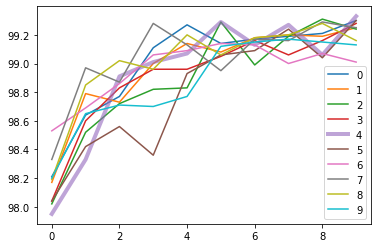

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(test_accL2[0])
plt.plot(test_accL2[1])
plt.plot(test_accL2[2])
plt.plot(test_accL2[3])
plt.plot(test_accL2[4],linewidth = 4 ,alpha=0.6) 
plt.plot(test_accL2[5])
plt.plot(test_accL2[6])
plt.plot(test_accL2[7])
plt.plot(test_accL2[8])
plt.plot(test_accL2[9])
plt.legend(["0","1","2","3","4","5","6","7","8","9"])
plt.show()


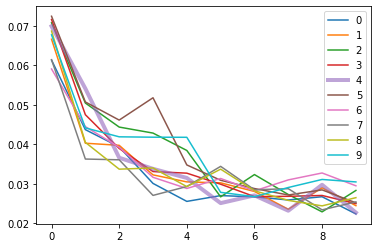

In [51]:
plt.plot(test_lossesL2[0])
plt.plot(test_lossesL2[1])
plt.plot(test_lossesL2[2])
plt.plot(test_lossesL2[3])
plt.plot(test_lossesL2[4],linewidth = 4 ,alpha=0.6)  
plt.plot(test_lossesL2[5])
plt.plot(test_lossesL2[6])
plt.plot(test_lossesL2[7])
plt.plot(test_lossesL2[8])
plt.plot(test_lossesL2[9])
plt.legend(["0","1","2","3","4","5","6","7","8","9"])
plt.show()


From the above graph, It's clear that **0.0004** is the best weight dacay value
